In [1]:
import sys
from pathlib import Path

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import metobs_toolkit
print(metobs_toolkit.__version__)

0.4.1a


# Verification pipeline CS-MASK

Put all data (observations, archivedir, metadata, templates etc) in a singel folder (use soft link for archivedir of model)

In [2]:
datafolder = Path("/home/thoverga/Documents/CSMASK/verif/data")

## Importing observations



In [14]:
#Set Paths to files

#TESTDATA:
obsdatafile = datafolder.joinpath('mini_test_vlinder_obs.csv')
metadatafile = metobs_toolkit.demo_metadatafile
templatefile = metobs_toolkit.demo_template


#BIGDATA
# obsdatafile = datafolder.joinpath('data_all_cs_stations.csv')
# metadatafile = datafolder.joinpath('metadata_all_cs_stations.csv')
# templatefile = datafolder.joinpath('csmask_template.json')




In [15]:
dataset = metobs_toolkit.Dataset()
dataset.import_data_from_file(
                    template_file=templatefile,
                    input_data_file=obsdatafile,
                    input_metadata_file=metadatafile,
                    )


Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the data file, but not in the template! They are skipped!
 ['Luchtdruk', 'Neerslagsom', 'Rukwind', 'Neerslagintensiteit', 'Globe Temperatuur', 'Luchtdruk_Zeeniveau']
The following columns are found in the metadata, but not in the template and are therefore ignored: 
['Network', 'stad', 'sponsor', 'benaming']
vlinder29 is not found in the metadat

### metadata

Extract extra metadata to serve as aggregation class for verification.

In [11]:
dataset.get_LCZ()

EEException: Invalid JSON payload received. Unexpected token.
 {"constantValue": [NaN, NaN]}}}}, "2": 
                    ^

### Apply syncronization

In [5]:
#Coarsen if needed
dataset.resample(target_freq='1h')

The present gaps are removed, new gaps are constructed for temp data of station vlinder02..
The present gaps are removed, new gaps are constructed for humidity data of station vlinder02..
The present gaps are removed, new gaps are constructed for wind_speed data of station vlinder02..
The present gaps are removed, new gaps are constructed for wind_direction data of station vlinder02..


### Apply QC 

In [6]:
target = 'temp'


#1. gross value check
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=-10.0,
            upper_threshold=42.0)

#2. persistence check
# dataset.persistence_check(
#             target_obstype=target,
#             timewindow='4h',
#             min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
# dataset.step_check(
#             target_obstype=target,
#             max_increase_per_second = 8.0 / 3600.0, #depends on standard unit!
#             max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit!


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documen

### Apply GF

### Inspect the data


                            General info of Dataset                             


--- Observational info ---

Dataset instance with:
  -28 number of stations
  -40320 number of records
  -4 types of sensor data are present.
  -Observations from 2022-09-01 00:00:00+00:00 -> 2022-09-15 23:00:00+00:00
  -Outlier info:
    -A total of {outldf.shape[0]} outliers are present.
      -label counts:
        -repetitions outlier: 1676
    -For these obstyes: ['temp']
    -For 28 stations: ['vlinder05', 'vlinder01', 'vlinder02', 'vlinder03', 'v...
  -Gaps info:
    -No gaps present.

--- Metadata info ---

  -28 number of stations
  -The following metadata is present: ['lat', 'lon', 'LCZ', 'school', 'geomet...

--- Modeldata info ---

  -Dataset instance without modeldata.



<Axes: title={'center': 'temp data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

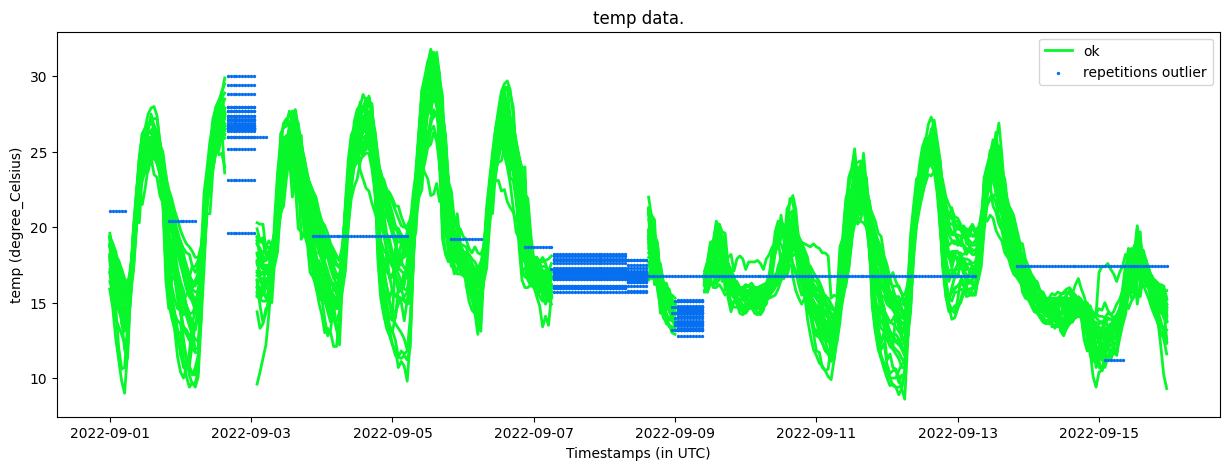

In [7]:
dataset.get_info()
dataset.make_plot(obstype = 'temp', colorby='label')

## Import model output

Note: ERA5 data can be extracted directly from the datataset, then skip this section.

In [ ]:
modelid = "AromeCy48t3_belgium_1.4"
variable_def=metobs_toolkit.default_SFX_fields

In [7]:
def load_all_netcdf_files(folder: Path, fileglobstr="*.nc", **kwargs) -> xr.Dataset:
    if not folder.is_dir():
        raise NotADirectoryError(f"{folder} is not a directory")
    files = sorted([str(f) for f in folder.glob(fileglobstr) if f.is_file()])
    if not files:
        raise FileNotFoundError(f"No NetCDF files found in {folder}")
    return xr.open_mfdataset(files, combine='by_coords', **kwargs)

def load_netcdf_file(file_path: Path, **kwargs) -> xr.Dataset:
    if not file_path.is_file():
        raise FileNotFoundError(f"{file_path} does not exist or is not a file")
    return xr.open_dataset(str(file_path), **kwargs)


In [ ]:
modeldataset = load_all_netcdf_files(datafolder,
                                    fileglobstr="archive/*/*/*/00/*.sfx.nc", engine='netcdf4')
mod = metobs_toolkit.ModelDataset(
                        modelID=modelid,
                        dataset=modeldataset,
                        field_defenitions=metobs_toolkit.default_SFX_fields)


The following variables are unmapped and are removed from the modeldataset: ['SFX.Q2M', 'SFX.Q2M_ISBA', 'SFX.Q2M_TEB', 'SFX.MER10M', 'SFX.H', 'SFX.RN']


SFX.T2M_TEB
SFX.T2M_ISBA
SFX.T2M
SFX.ZON10M


In [9]:
modeldataset


<xarray.Dataset> Size: 422MB
Dimensions:         (validtime: 35, y: 364, x: 412, level: 90, reference_time: 1)
Coordinates:
    lon             (x, y) float64 1MB dask.array<chunksize=(412, 364), meta=np.ndarray>
  * x               (x) int64 3kB 0 1 2 3 4 5 6 ... 405 406 407 408 409 410 411
  * level           (level) int64 720B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
  * y               (y) int64 3kB 363 362 361 360 359 358 357 ... 6 5 4 3 2 1 0
  * validtime       (validtime) datetime64[ns] 280B 2020-08-01 ... 2020-08-02...
    lat             (x, y) float64 1MB dask.array<chunksize=(412, 364), meta=np.ndarray>
  * reference_time  (reference_time) datetime64[ns] 8B 2020-08-01
Data variables:
    SFX.T2M_ISBA    (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.T2M_TEB     (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.MER10M      (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.Q2M_ISBA    (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.ZON10M      (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.Q2M         (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.RN          (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.Q2M_TEB     (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.H           (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
    SFX.T2M         (validtime, y, x) float64 42MB dask.array<chunksize=(1, 364, 412), meta=np.ndarray>
Attributes: (12/47)
    CADRE-DIMENSIONS:     [ 191  384  432   90 -215]
    CADRE-FRANKSCHMI:     [0. 0. 0. 0.]
    CADRE-REDPOINPOL:     [     0      1      1    412      1    364     16  ...
    CADRE-SINLATITUD:     [-1.00000000e+00  7.74944489e-01  7.94124810e-02  8...
    CADRE-FOCOHYBRID:     [1.01325000e+05 0.00000000e+00 2.68273558e-02 3.698...
    DATE-DES-DONNEES:     [2020    8    1    0    0    1    0    0    1    0 ...
    ...                   ...
    proj4_lat_1:          50.8
    proj4_lat_2:          50.8
    proj4_R:              6371229
    levels_ref_pressure:  101325.0
    levels_A:             [0.00000000e+00 2.68273558e-02 3.69808960e-02 4.851...
    levels_B:             [0.         0.         0.         0.         0.    ...

### Plot spatial


## Clip spatial data to timeseries

The goal is that the spatial modeloutput is converted to timeseries at the stations locations. This is done by importing the modeldata to the (observational) dataset.


In [11]:
# dataset.get_NWP_timeseries_data(modeldataset=mod)

### (Optional) era5 as modeldata

In [12]:
era5_manager = metobs_toolkit.default_GEE_datasets["ERA5-land"]

# era5_data = dataset.get_gee_timeseries_data(
#     geedynamicdatasetmanager=era5_manager,
#     startdt_utc=None,  # raises error in metadata-only case
#     enddt_utc=None,
#     target_obstypes=["temp"],
#     get_all_bands=False,
#     drive_filename=None,
#     # drive_folder="gee_timeseries_data",
#     force_direct_transfer=False,
#     force_to_drive=False,
# )


dataset.import_gee_data_from_file(filepath="/home/thoverga/Downloads/ERA5-land_vlinders_demo.csv",
                                  geedynamicdatasetmanager=era5_manager)



temp     pressure
name      datetime                                         
vlinder01 2022-09-01 00:00:00+00:00  18.394525  1017.902695
          2022-09-01 01:00:00+00:00  17.799753  1017.461797
          2022-09-01 02:00:00+00:00  17.415353  1017.439766
          2022-09-01 03:00:00+00:00  16.820734  1017.180352
          2022-09-01 04:00:00+00:00  16.450281  1016.983633
...                                        ...          ...
vlinder28 2022-09-15 20:00:00+00:00  14.408151  1010.590937
          2022-09-15 21:00:00+00:00  13.831171  1010.626992
          2022-09-15 22:00:00+00:00  13.174661  1011.179062
          2022-09-15 23:00:00+00:00  12.936517  1010.934922
          2022-09-16 00:00:00+00:00  12.735727  1010.891836

[10108 rows x 2 columns]

### timeseries plots



In [13]:
# dataset.get_station('vlinder05').make_plot(obstype='temp', show_modeldata=True,
#                                            trg_modelID=modelid)


# Verification

Verification is handled by the `metobs_toolkit.Verification` class. In pracktice, this is just a wrapper on the Dataset/Station class. But this id done so to keep it in parallel of these classes, rather than adjusting these classes.

In [14]:
shift_tolerance = pd.Timedelta('5min')
target_obstype='temp'

In [15]:

ver = metobs_toolkit.Verification(obj=dataset)
verifdf = ver._create_verifdf(target_obstype=target_obstype,
                              shift_tolerance=shift_tolerance)
verifdf


fc  observation
datetime                  name                             
2022-09-01 00:00:00+00:00 vlinder01  18.394526    18.799999
                          vlinder02  18.451166    19.400000
                          vlinder03  17.931635    17.000000
                          vlinder04  17.931635    15.900000
                          vlinder05  18.222651          NaN
...                                        ...          ...
2022-09-16 00:00:00+00:00 vlinder24  13.511118          NaN
                          vlinder25  13.323618          NaN
                          vlinder26  12.151743          NaN
                          vlinder27  13.153696          NaN
                          vlinder28  12.735727          NaN

[10108 rows x 2 columns]

## Verification: values

Verification results of values (and differnces with refernces).



(<Axes: title={'center': 'Timeseries of temp (obs & fc)\n (originates from temperature_2m)'}, ylabel='temp (degree_Celsius)'>,
 <Axes: title={'center': 'Residuals'}, ylabel='fc - obs (in degree_Celsius)'>)

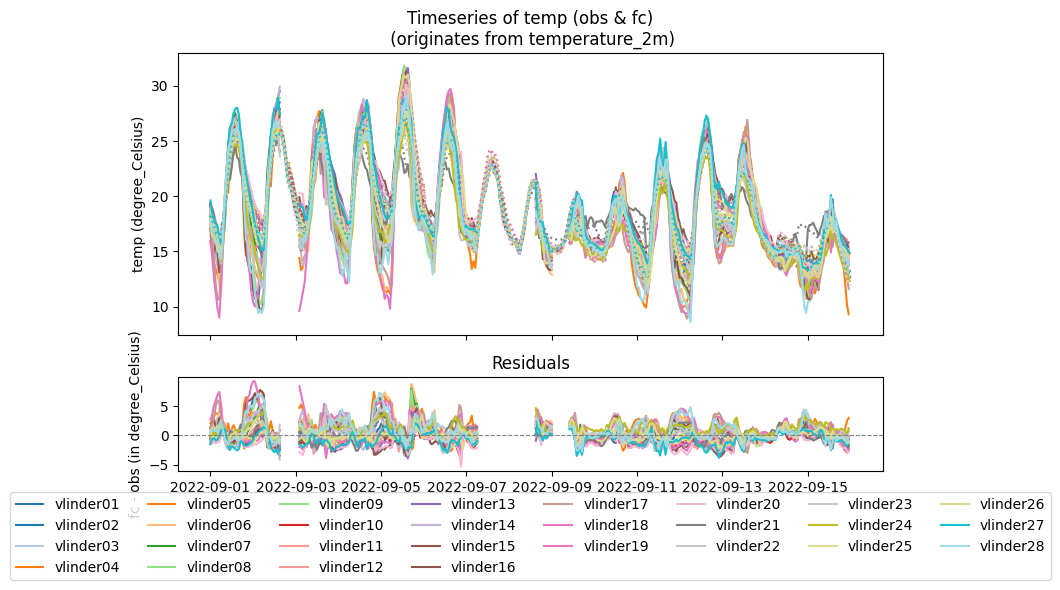

In [16]:
ver.plot_timeseries_of_obs_and_fc(target_obstype=target_obstype,
                                  )

### Temperatures aggregated


<Axes: title={'center': 'ModelObstype instance of temp forecasted values grouped per name.'}, xlabel='hour', ylabel='temp (degree_Celsius))'>

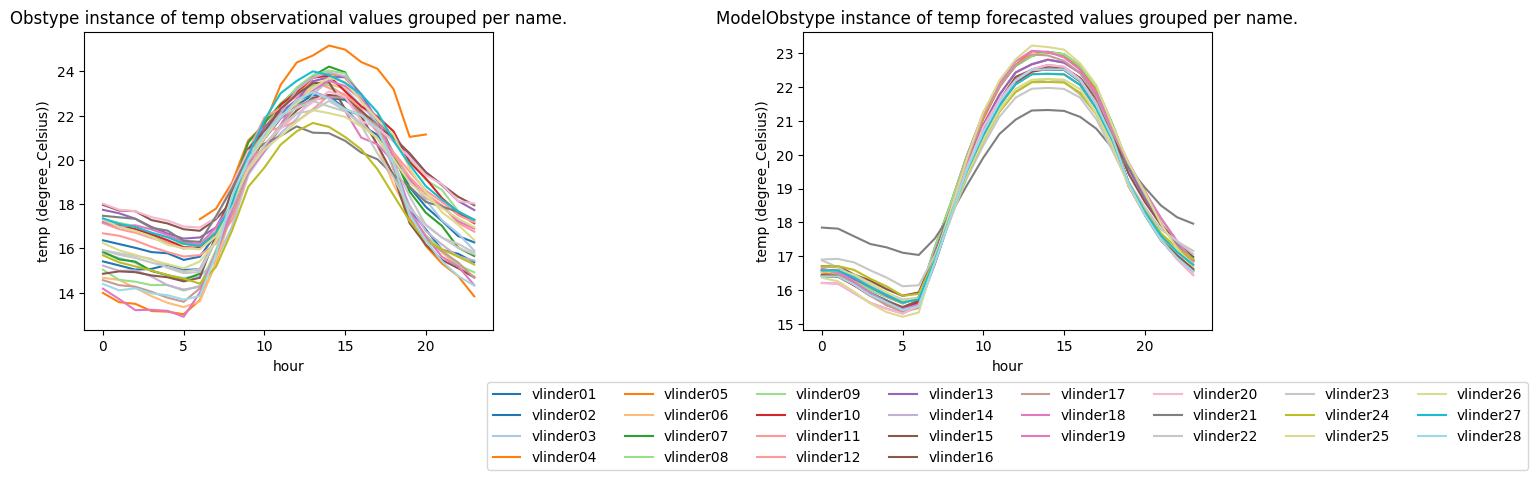

In [ ]:
import metobs_toolkit.plot_collection as plotting

#make two panels (left -> observations, right -> fc)
fig, (ax0, ax1) = plt.subplots(figsize=(15,5), ncols=2)
#Make sure the same colorscheme is used.
colorby='name'
colmap = plotting.create_categorical_color_map(catlist = ver.obj.metadf.reset_index()[colorby])


ver.plot_value_cycles(target_obstype=target_obstype,
                      reference_station=None, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax0,
                      output_is_obs = True)
ax0.get_legend().remove() #is set by the ax1


ver.plot_value_cycles(target_obstype=target_obstype,
                      reference_station=None, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax1,
                      output_is_obs = False)


<Axes: title={'center': 'ModelObstype instance of temp forecasted differences with vlinder02, grouped per LCZ.'}, xlabel='hour', ylabel='temp (degree_Celsius))'>

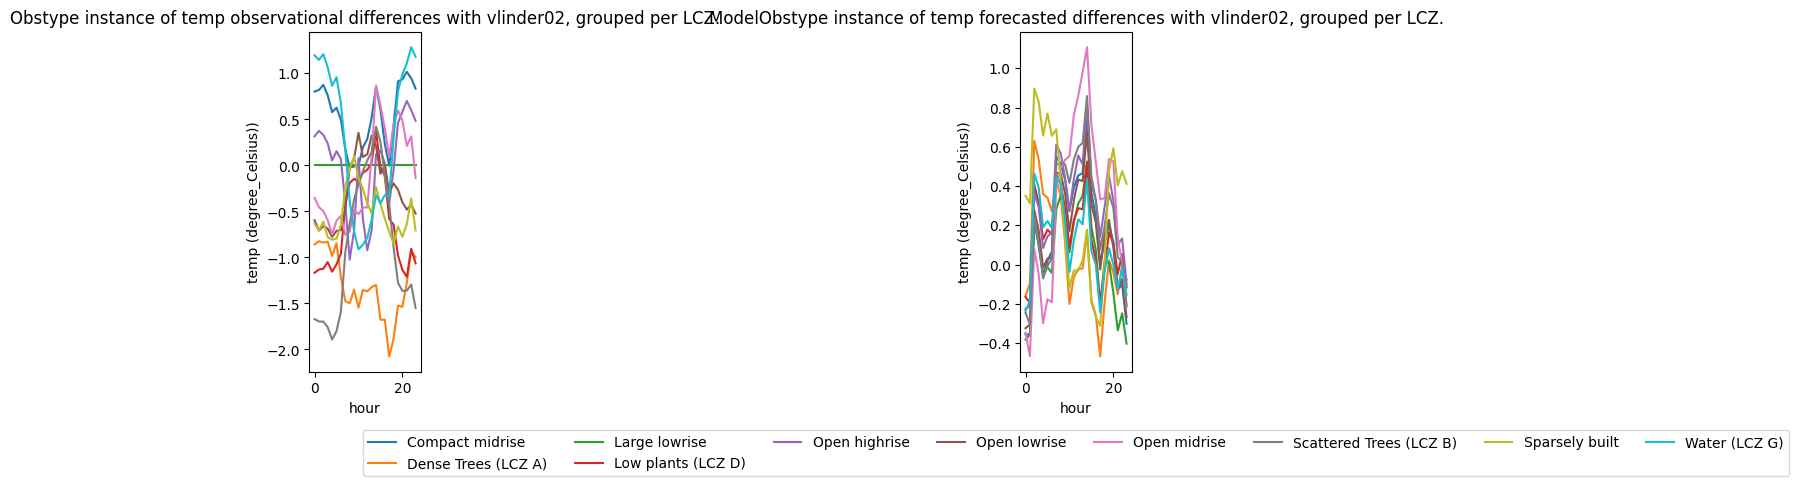

In [30]:
refstation = 'vlinder02'


#make two panels (left -> observations, right -> fc)
fig, (ax0, ax1) = plt.subplots(figsize=(15,5), ncols=2)
#Make sure the same colorscheme is used.
colorby='LCZ'
colmap = plotting.create_categorical_color_map(catlist = ver.obj.metadf.reset_index()[colorby])


ver.plot_value_cycles(target_obstype=target_obstype,
                      reference_station=refstation, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax0,
                      output_is_obs = True)
ax0.get_legend().remove() #is set by the ax1


ver.plot_value_cycles(target_obstype=target_obstype,
                      reference_station=refstation, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax1,
                      output_is_obs = False)

## Verification : scores
### Aggregationgroups


In [18]:
agg_scores_group = ['datetime'] #Include all levels needed for the plot
xax_lvl = 'datetime'
colorlvl = None
to_plot_value= None
to_plot_lvl = 'score'

In [19]:
scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)
print(scoringdf.head())

datetime                   score     
2022-09-01 00:00:00+00:00  rmse           1.050763
                           mae            0.882958
                           bias          -0.022778
                           samplesize    27.000000
2022-09-01 01:00:00+00:00  rmse           1.260945
Name: value, dtype: float64


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score.'}, xlabel='datetime'>

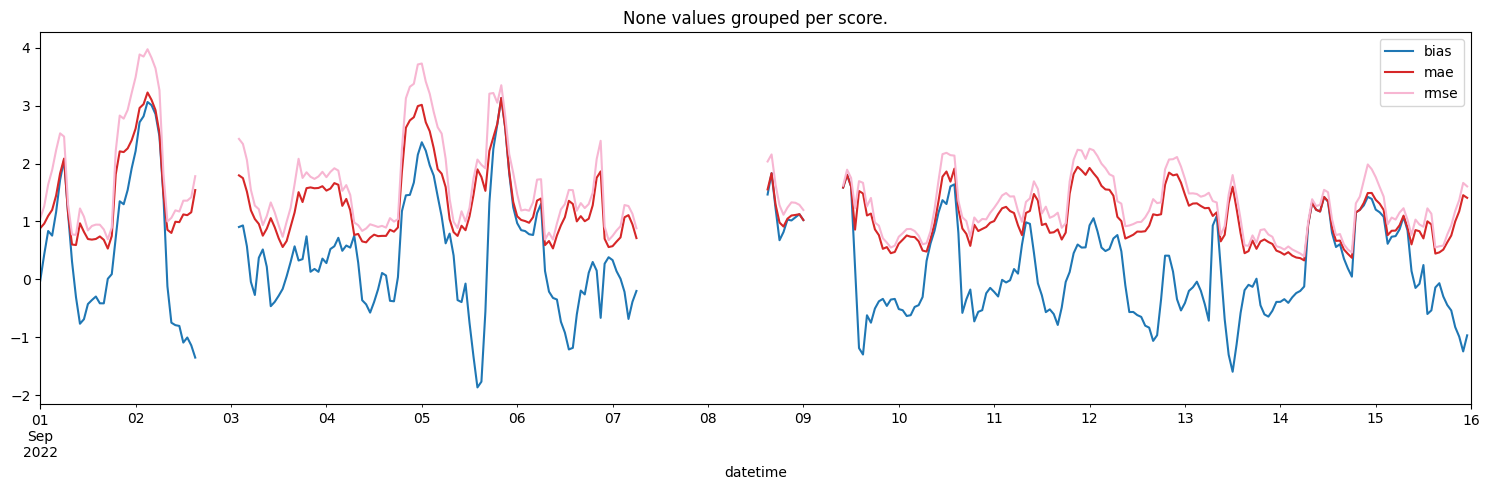

In [20]:
#Make plot

#Optional: filter out scores with other 'units' 
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score.'}, xlabel='name'>

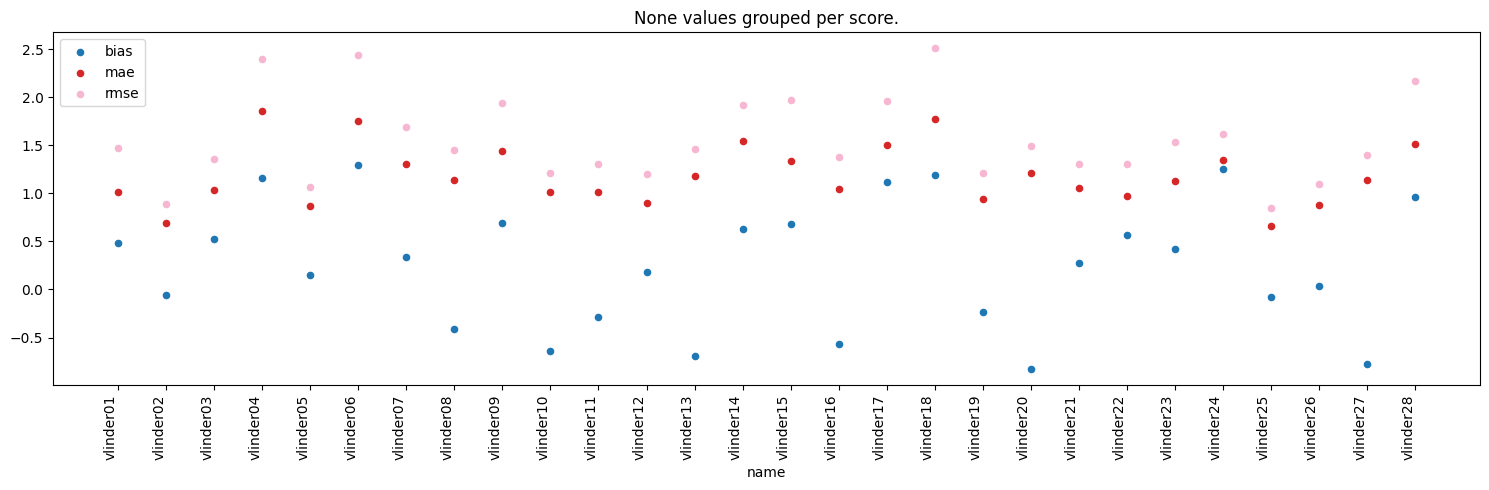

In [21]:
# aggregated to stationnames
agg_scores_group = ['name'] #Include all levels needed for the plot
xax_lvl = 'name'
colorlvl = None
to_plot_value= None
to_plot_lvl = 'score'

scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

### Diurnal aggregation

In this section we make compute diurnal scores and plots.


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'rmse values grouped per LCZ.'}, xlabel='hour', ylabel='rmse'>

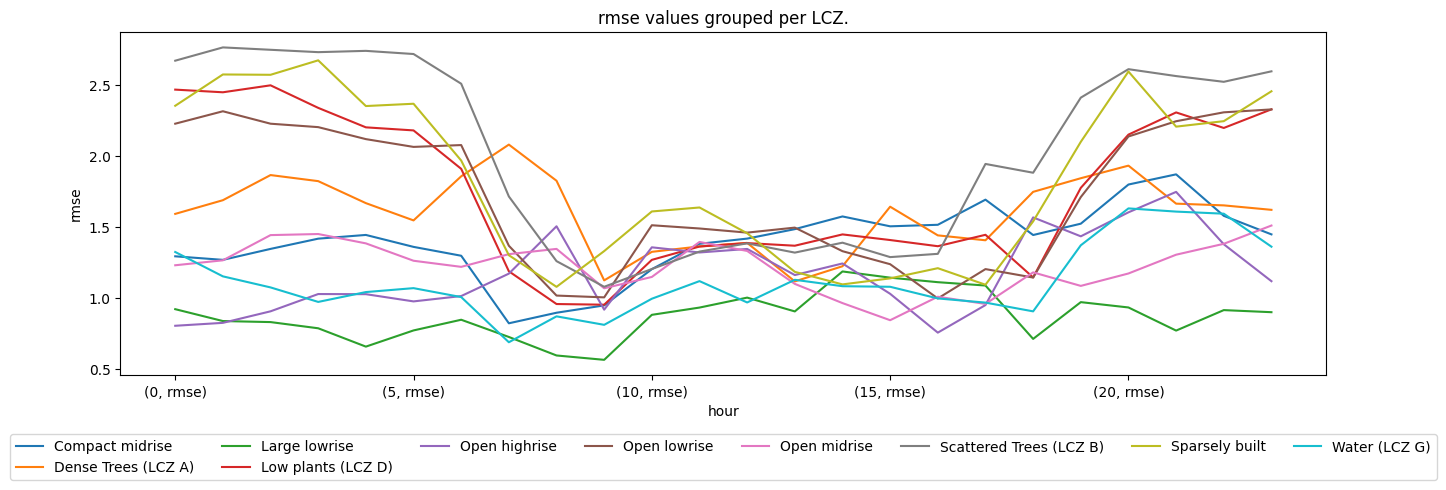

In [22]:
agg_scores_group = ['hour', 'LCZ'] #hour makes it diurnal !! 
xax_lvl = 'hour'
colorlvl = 'LCZ'
to_plot_value= 'rmse' # thus all scores under the 'score' lvel
to_plot_lvl = 'score'

#Compute scores
scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

#Drop samplesizes
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

#plot
ver.plot_scoring(
        scoringdf=scoringdf,
        xaxis_level=xax_lvl,
        color_level=colorlvl,
        to_plot_value=to_plot_value,
        to_plot_level=to_plot_lvl)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score.'}, xlabel='hour'>

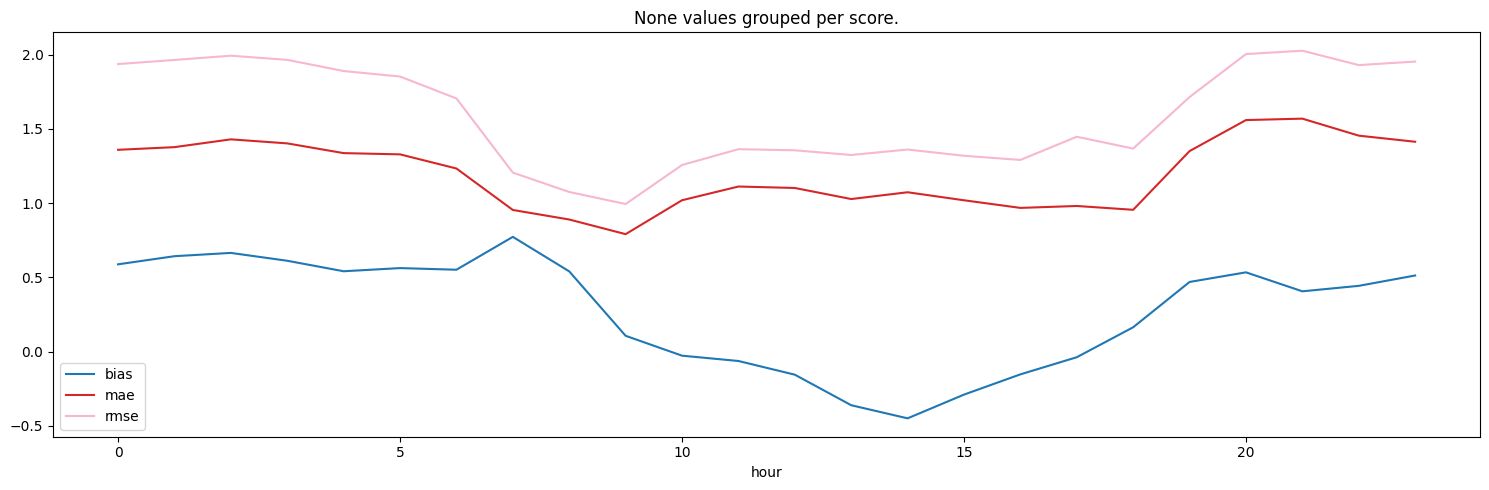

In [31]:
agg_scores_group = ['hour'] #hour makes it diurnal !! 
xax_lvl = 'hour'
colorlvl = 'score'
to_plot_value= None # thus all scores under the 'score' lvel
to_plot_lvl = 'score'


#Compute scores
scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

#Drop samplesizes
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

#plot
ver.plot_scoring(
        scoringdf=scoringdf,
        xaxis_level=xax_lvl,
        color_level=colorlvl,
        to_plot_value=to_plot_value,
        to_plot_level=to_plot_lvl)